#Representación, Preprocesamiento, Clasificación, Agrupación **

Este cuaderno reproduce y amplía los **códigos prácticos** de la presentación (BoW, TF‑IDF, preprocesamiento, modelos basados en reglas, clasificación con Naïve Bayes, evaluación y *clustering* con K‑Means), **excluyendo** LDA/NMF y cualquier otro **modelado de tópicos**.

**Cómo usarlo**  
1. (Opcional) **Subir un CSV propio** con columnas: `texto` y, si existe, `label`.  
2. (Alternativa) **Generar un dataset de ejemplo** directamente desde el cuaderno.  
3. Ejecutar las secciones en orden.

## 1) Instalaciones (si usas Colab)

In [1]:
# Si estás en Google Colab, descomenta estas líneas para instalar dependencias.
# Recomendado ejecutar y, cuando termine, reiniciar el entorno si lo pide.
# %%capture
!pip install -q scikit-learn nltk spacy matplotlib
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 65.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 2) Imports y utilidades

In [2]:
import os
import re
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

# NLTK con descargas robustas
import nltk
# Intentamos ambos recursos, por compatibilidad entre versiones de NLTK
try:
    nltk.download('punkt', quiet=True)
except Exception:
    pass
try:
    nltk.download('punkt_tab', quiet=True)
except Exception:
    pass
try:
    nltk.download('stopwords', quiet=True)
except Exception:
    pass

from nltk.corpus import stopwords
# Si falla el import del tokenizador, usaremos fallback más abajo
try:
    from nltk.tokenize import word_tokenize
    _has_word_tokenize = True
except Exception:
    _has_word_tokenize = False

# spaCy (opcional, para lematización en español)
try:
    import spacy
    _nlp = spacy.load('es_core_news_sm')
except Exception as e:
    _nlp = None  # Si no está instalado, el cuaderno seguirá funcionando sin spaCy
    print("spaCy/es_core_news_sm no disponible. Si lo necesitas, instala y descarga el modelo en la sección 1.")

# Utilidad: mostrar una barra simple de valores (ej. top términos)
def plot_bar(names, values, title, xlabel, ylabel):
    plt.figure()
    idx = np.arange(len(names))
    plt.bar(idx, values)
    plt.xticks(idx, names, rotation=45, ha='right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Utilidad: matriz de confusión sin librerías externas
def plot_confusion_matrix(cm, classes, title='Matriz de confusión'):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center")
    plt.tight_layout()
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

## 3) Datos: **Sube tu CSV** o **genera uno de ejemplo**

- Estructura esperada si subes: columna `texto` (obligatoria) y opcionalmente `label` (ej. _positivo/negativo_).
- Si no tienes datos, ejecuta la celda **Generar dataset de ejemplo**.

In [8]:
# Opción A) SUBIR ARCHIVO (ejecuta en Colab)
from google.colab import files
uploaded = files.upload()  # Selecciona tu CSV
df = None
for fn in uploaded.keys():
     if fn.endswith('.csv'):
         df = pd.read_csv(io.BytesIO(uploaded[fn]))
         break
if df is None:
     print("No se encontró un CSV. Alternativamente, usa la Opción B para generar un dataset de ejemplo.")

# Para este entorno local (no Colab), df seguirá sin definirse hasta que uses la Opción B
try:
    df
except NameError:
    pass

Saving dataset_sentimiento.csv to dataset_sentimiento (1).csv


In [ ]:
# Opción B) GENERAR DATASET DE EJEMPLO
ejemplos_positivos = [
    "Me encanta este producto, llegó rápido y funciona perfecto",
    "Excelente calidad, lo volvería a comprar sin dudar",
    "Muy buena atención al cliente, resolvieron mi problema",
    "Totalmente recomendable, superó mis expectativas",
    "La experiencia fue agradable y el envío fue puntual",
    "El curso fue útil y muy bien explicado",
    "Servicio impecable; quedé satisfecho",
    "Gran relación calidad-precio, estoy feliz con la compra",
    "El empaque y la presentación estuvieron perfectos",
    "La app es intuitiva y fácil de usar"
]

ejemplos_negativos = [
    "Horrible experiencia, el producto llegó dañado",
    "Odio este servicio, tardaron demasiado en responder",
    "Muy mala calidad, no lo recomiendo",
    "Pésimo soporte, nadie resolvió mi problema",
    "El envío fue un desastre y llegó incompleto",
    "La app se cierra y es lenta",
    "Defectuoso y frágil, duró un día",
    "No cumple lo prometido, me siento estafado",
    "Atención deficiente, respuestas automáticas y sin solución",
    "No volvería a comprar aquí"
]

# Expandimos para tener más observaciones
texto = ejemplos_positivos * 3 + ejemplos_negativos * 3
label = (["positivo"] * len(ejemplos_positivos) + ["negativo"] * len(ejemplos_negativos)) * 3

df_example = pd.DataFrame({"texto": texto, "label": label})
print(df_example.head())
print(df_example['label'].value_counts())

# Guardamos a CSV por si deseas descargar y luego "subir" con la Opción A
df_example.to_csv("dataset_sentimientos.csv", index=False)
print("Archivo 'dataset_sentimientos.csv' creado en el entorno actual.")

                                               texto     label
0  Me encanta este producto, llegó rápido y funci...  positivo
1  Excelente calidad, lo volvería a comprar sin d...  positivo
2  Muy buena atención al cliente, resolvieron mi ...  positivo
3   Totalmente recomendable, superó mis expectativas  positivo
4  La experiencia fue agradable y el envío fue pu...  positivo
label
positivo    30
negativo    30
Name: count, dtype: int64
Archivo 'dataset_sentimientos.csv' creado en el entorno actual.


## 4) Preprocesamiento (NLTK y opcional spaCy)

In [4]:
SPANISH_STOPWORDS = set(stopwords.words('spanish'))


def limpiar_texto_basic(t):
    # Minúsculas + eliminación de caracteres no alfanuméricos básicos
    t = t.lower()
    t = re.sub(r"[^a-záéíóúñü0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def tokenizar_filtrar(t):
    # Fallback robusto si NLTK word_tokenize no está disponible
    if globals().get("_has_word_tokenize", False):
        try:
            tokens = word_tokenize(t, language="spanish")
        except LookupError:
            # Intento de descarga diferida (por si falla en tiempo de ejecución)
            try:
                import nltk
                nltk.download('punkt')
                nltk.download('punkt_tab')
                tokens = word_tokenize(t, language="spanish")
            except Exception:
                tokens = re.findall(r"\b\w+\b", t, flags=re.UNICODE)
    else:
        tokens = re.findall(r"\b\w+\b", t, flags=re.UNICODE)

 # Filtrado: elimina stopwords y palabras cortas
    tokens = [w for w in tokens if w not in SPANISH_STOPWORDS and len(w) > 2]
    return tokens

def lematizar_spacy(tokens):
    if _nlp is None:
        return tokens  # si spaCy no está disponible, devolvemos tokens sin lematizar
    doc = _nlp(" ".join(tokens))
    return [tok.lemma_ for tok in doc if not tok.is_stop and len(tok.lemma_) > 2]

# Elegir la fuente de datos: df si subiste; si no, usamos df_example
data = None

# Fuente de datos
try:
    data = df.copy()
except Exception:
    data = df_example.copy()

data['texto_clean'] = data['texto'].apply(limpiar_texto_basic)
data['tokens'] = data['texto_clean'].apply(tokenizar_filtrar)
if _nlp is not None:
    data['lemmas'] = data['tokens'].apply(lematizar_spacy)
else:
    data['lemmas'] = data['tokens']

data.head(40)

,texto,label,texto_clean,tokens,lemmas
0,estoy feliz con la compra realizada.,positivo,estoy feliz con la compra realizada,"[feliz, compra, realizada]","[feliz, compra, realizado]"
1,El empaque y presentación fueron impecables. Á...,positivo,el empaque y presentación fueron impecables ág...,"[empaque, presentación, impecables, águila, po...","[empaque, presentación, impecable, águila, por..."
2,Buen precio y excelente servicio.,positivo,buen precio y excelente servicio,"[buen, precio, excelente, servicio]","[precio, excelente, servicio]"
3,"Recomendaría este servicio sin duda. Perelló, ...",positivo,recomendaría este servicio sin duda perelló co...,"[recomendaría, servicio, duda, perelló, conesa...","[recomendarir, servicio, duda, perellar, cones..."
4,Excelenteatenciónyentregarápida.Ballester-Merc...,positivo,excelenteatenciónyentregarápida ballester merc...,"[excelenteatenciónyentregarápida, ballester, m...","[excelenteatenciónyentregarápir, ballester, me..."
5,Estoy feliz con la compra realizada.,positivo,estoy feliz con la compra realizada,"[feliz, compra, realizada]","[feliz, compra, realizado]"
6,Estoy feliz con la compra realizada.!!!,positivo,estoy feliz con la compra realizada,"[feliz, compra, realizada]","[feliz, compra, realizado]"
7,Recomendaría este servicio sin duda. Bru and S...,positivo,recomendaría este servicio sin duda bru and so...,"[recomendaría, servicio, duda, bru, and, sons,...","[recomendarir, servicio, duda, bru, and, sons,..."
8,"La experiencia fue muy positiva. Lorenzo, Rebo...",positivo,la experiencia fue muy positiva lorenzo reboll...,"[experiencia, positiva, lorenzo, rebollo, and,...","[experiencia, positivo, lorenzo, rebollo, and,..."
9,recomendaría este servicio sin duda.,negativo,recomendaría este servicio sin duda,"[recomendaría, servicio, duda]","[recomendarir, servicio, duda]"


## Nuevo Actividad 2 Código modificado con nuevas stopwords: "muy", "lo", "el", "mi", "este"

In [9]:
# Stopwords base de NLTK
SPANISH_STOPWORDS = set(stopwords.words('spanish'))

# Agregar stopwords personalizadas
custom_stopwords = {"muy", "lo", "el", "mi", "este", "fue"}
SPANISH_STOPWORDS.update(custom_stopwords)

def limpiar_texto_basic(t):
    t = t.lower()
    t = re.sub(r"[^a-záéíóúñü0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    tokens = [w for w in t.split() if w not in SPANISH_STOPWORDS and len(w) > 2]
    return " ".join(tokens)  # devuelve texto limpio sin stopwords


def tokenizar_filtrar(t):
    if globals().get("_has_word_tokenize", False):
        try:
            tokens = word_tokenize(t, language="spanish")
        except LookupError:
            import nltk
            nltk.download('punkt')
            nltk.download('punkt_tab')
            tokens = word_tokenize(t, language="spanish")
        except Exception:
            tokens = re.findall(r"\b\w+\b", t, flags=re.UNICODE)
    else:
        tokens = re.findall(r"\b\w+\b", t, flags=re.UNICODE)

    # Filtrado: elimina stopwords y palabras cortas
    tokens = [w for w in tokens if w not in SPANISH_STOPWORDS and len(w) > 2]
    return tokens

def lematizar_spacy(tokens):
    if _nlp is None:
        return tokens
    doc = _nlp(" ".join(tokens))
    return [tok.lemma_ for tok in doc if not tok.is_stop and len(tok.lemma_) > 2]

# Fuente de datos
try:
    data = df.copy()
except Exception:
    data = df_example.copy()

data['texto_clean'] = data['texto'].apply(limpiar_texto_basic)
data['tokens'] = data['texto_clean'].apply(tokenizar_filtrar)
if _nlp is not None:
    data['lemmas'] = data['tokens'].apply(lematizar_spacy)
else:
    data['lemmas'] = data['tokens']

data.head(20)


,texto,label,texto_clean,tokens,lemmas
0,estoy feliz con la compra realizada.,positivo,feliz compra realizada,"[feliz, compra, realizada]","[feliz, compra, realizado]"
1,El empaque y presentación fueron impecables. Á...,positivo,empaque presentación impecables águila porcel ...,"[empaque, presentación, impecables, águila, po...","[empaque, presentación, impecable, águila, por..."
2,Buen precio y excelente servicio.,positivo,buen precio excelente servicio,"[buen, precio, excelente, servicio]","[precio, excelente, servicio]"
3,"Recomendaría este servicio sin duda. Perelló, ...",positivo,recomendaría servicio duda perelló conesa and ...,"[recomendaría, servicio, duda, perelló, conesa...","[recomendarir, servicio, duda, perellar, cones..."
4,Excelenteatenciónyentregarápida.Ballester-Merc...,positivo,excelenteatenciónyentregarápida ballester merc...,"[excelenteatenciónyentregarápida, ballester, m...","[excelenteatenciónyentregarápir, ballester, me..."
5,Estoy feliz con la compra realizada.,positivo,feliz compra realizada,"[feliz, compra, realizada]","[feliz, compra, realizado]"
6,Estoy feliz con la compra realizada.!!!,positivo,feliz compra realizada,"[feliz, compra, realizada]","[feliz, compra, realizado]"
7,Recomendaría este servicio sin duda. Bru and S...,positivo,recomendaría servicio duda bru and sons convenció,"[recomendaría, servicio, duda, bru, and, sons,...","[recomendarir, servicio, duda, bru, and, sons,..."
8,"La experiencia fue muy positiva. Lorenzo, Rebo...",positivo,experiencia positiva lorenzo rebollo and mariñ...,"[experiencia, positiva, lorenzo, rebollo, and,...","[experiencia, positivo, lorenzo, rebollo, and,..."
9,recomendaría este servicio sin duda.,negativo,recomendaría servicio duda,"[recomendaría, servicio, duda]","[recomendarir, servicio, duda]"


## 5) Vectorización Bag of Words (BoW)

Dimensión BoW: (210, 299)
Vocabulario (primeros 20): ['albacete' 'albacetefueundesastre' 'alberto' 'alcalde' 'alcolea'
 'alegria' 'alicante' 'amorós' 'amé' 'and' 'andreu' 'andrésllcmeconvenció'
 'anguita' 'arcos' 'asturias' 'atención' 'ayudan' 'badajoz' 'badía'
 'baena']


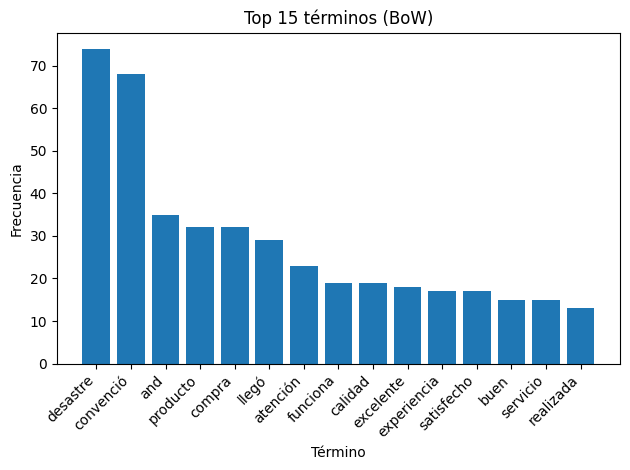

In [10]:
corpus = data['texto_clean'].tolist()
bow_vec = CountVectorizer()
X_bow = bow_vec.fit_transform(corpus)
print("Dimensión BoW:", X_bow.shape)
print("Vocabulario (primeros 20):", bow_vec.get_feature_names_out()[:20])

# Términos más frecuentes (suma por columna)
term_freq = np.asarray(X_bow.sum(axis=0)).ravel()
idx_sorted = term_freq.argsort()[::-1][:15]
top_terms = bow_vec.get_feature_names_out()[idx_sorted]
top_counts = term_freq[idx_sorted]
plot_bar(top_terms, top_counts, "Top 15 términos (BoW)", "Término", "Frecuencia")

## 6) Vectorización TF‑IDF

Dimensión TF‑IDF: (210, 299)
Vocabulario (primeros 20): ['albacete' 'albacetefueundesastre' 'alberto' 'alcalde' 'alcolea'
 'alegria' 'alicante' 'amorós' 'amé' 'and' 'andreu' 'andrésllcmeconvenció'
 'anguita' 'arcos' 'asturias' 'atención' 'ayudan' 'badajoz' 'badía'
 'baena']


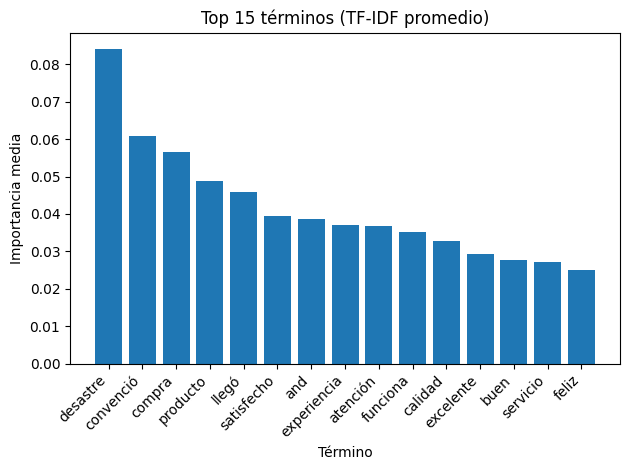

In [11]:
tfidf_vec = TfidfVectorizer()
X_tfidf = tfidf_vec.fit_transform(corpus)
print("Dimensión TF‑IDF:", X_tfidf.shape)
print("Vocabulario (primeros 20):", tfidf_vec.get_feature_names_out()[:20])

# Top términos por TF-IDF promedio
tfidf_mean = np.asarray(X_tfidf.mean(axis=0)).ravel()
idx_sorted = tfidf_mean.argsort()[::-1][:15]
top_terms = tfidf_vec.get_feature_names_out()[idx_sorted]
top_scores = tfidf_mean[idx_sorted]
plot_bar(top_terms, top_scores, "Top 15 términos (TF‑IDF promedio)", "Término", "Importancia media")

## 7) Modelos basados en reglas (demostración simple)

In [12]:
lex_pos = {"encanta","excelente","buena","recomendable","agradable","útil","impecable","feliz","perfecto","intuitiva"}
lex_neg = {"horrible","odio","mala","pésimo","desastre","lenta","defectuoso","estafado","deficiente","dañado"}

def regla_sentimiento(texto):
    t = limpiar_texto_basic(texto)
    toks = set(tokenizar_filtrar(t))
    pos = len(toks & lex_pos)
    neg = len(toks & lex_neg)
    if pos > neg:
        return "positivo"
    elif neg > pos:
        return "negativo"
    else:
        return "neutro"

muestras = [
    "El servicio fue excelente y la app es intuitiva",
    "Horrible atención, el envío fue un desastre",
    "Cumple, pero nada sobresaliente"
]
for s in muestras:
    print(s, "→", regla_sentimiento(s))

El servicio fue excelente y la app es intuitiva → positivo
Horrible atención, el envío fue un desastre → negativo
Cumple, pero nada sobresaliente → neutro


## 8) Clasificación supervisada (Naïve Bayes) + evaluación

Accuracy: 0.8301886792452831
              precision    recall  f1-score   support

    negativo       0.81      0.84      0.82        25
    positivo       0.85      0.82      0.84        28

    accuracy                           0.83        53
   macro avg       0.83      0.83      0.83        53
weighted avg       0.83      0.83      0.83        53



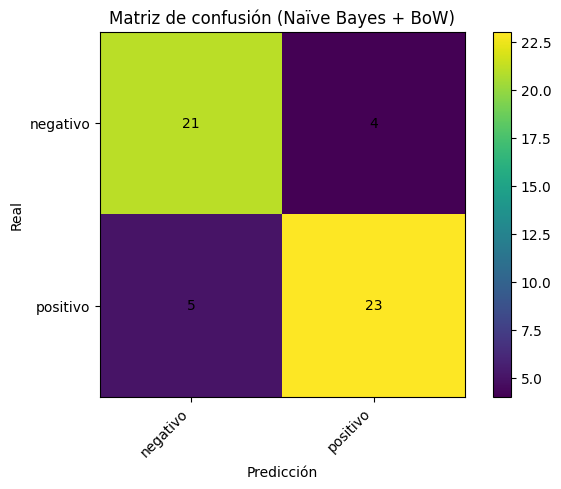

CV Accuracy (TF‑IDF + NB): 0.8762 +/- 0.0883


In [13]:
if 'label' in data.columns:
    y = data['label'].values
else:
    # Si no hay etiqueta, creamos una sintética (solo para mostrar el flujo)
    y = np.array(["positivo" if i % 2 == 0 else "negativo" for i in range(len(data))])

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.25, random_state=42, stratify=y)

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matriz de confusión
labels = sorted(list(set(y)))
cm = confusion_matrix(y_test, y_pred, labels=labels)
plot_confusion_matrix(cm, classes=labels, title="Matriz de confusión (Naïve Bayes + BoW)")

# Cross-validation con TF-IDF para variar la representación
scores = cross_val_score(MultinomialNB(), X_tfidf, y, cv=5)
print("CV Accuracy (TF‑IDF + NB):", scores.mean().round(4), "+/-", scores.std().round(4))

Accuracy (LinearSVC + BoW): 0.8490566037735849
              precision    recall  f1-score   support

    negativo       0.90      0.76      0.83        25
    positivo       0.81      0.93      0.87        28

    accuracy                           0.85        53
   macro avg       0.86      0.84      0.85        53
weighted avg       0.86      0.85      0.85        53



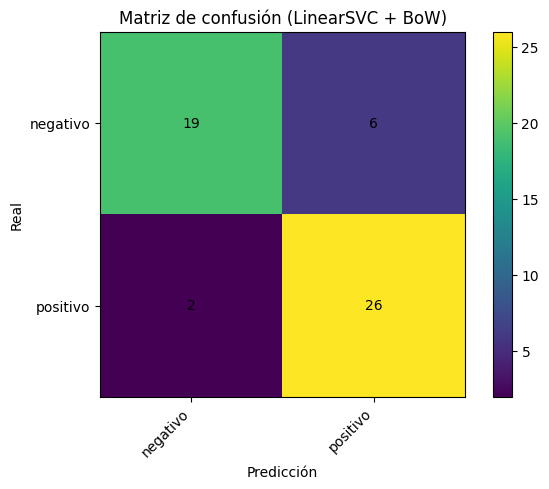

CV Accuracy (TF‑IDF + LinearSVC): 0.8905 +/- 0.0732


In [15]:
from sklearn.svm import LinearSVC

if 'label' in data.columns:
    y = data['label'].values
else:
    # Si no hay etiqueta, creamos una sintética (solo para mostrar el flujo)
    y = np.array(["positivo" if i % 2 == 0 else "negativo" for i in range(len(data))])

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.25, random_state=42, stratify=y)

# Usando LinearSVC en lugar de MultinomialNB
clf_svc = LinearSVC()
clf_svc.fit(X_train, y_train)
y_pred_svc = clf_svc.predict(X_test)

print("Accuracy (LinearSVC + BoW):", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

# Matriz de confusión
labels = sorted(list(set(y)))
cm_svc = confusion_matrix(y_test, y_pred_svc, labels=labels)
plot_confusion_matrix(cm_svc, classes=labels, title="Matriz de confusión (LinearSVC + BoW)")

# Cross-validation con TF-IDF para variar la representación
scores_svc = cross_val_score(LinearSVC(), X_tfidf, y, cv=5)
print("CV Accuracy (TF‑IDF + LinearSVC):", scores_svc.mean().round(4), "+/-", scores_svc.std().round(4))

Accuracy (LogisticRegression + BoW): 0.8490566037735849
              precision    recall  f1-score   support

    negativo       0.90      0.76      0.83        25
    positivo       0.81      0.93      0.87        28

    accuracy                           0.85        53
   macro avg       0.86      0.84      0.85        53
weighted avg       0.86      0.85      0.85        53



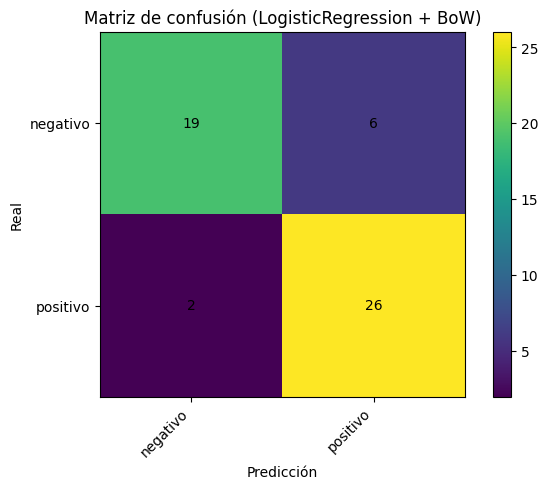

CV Accuracy (TF‑IDF + LogisticRegression): 0.8857 +/- 0.0744


In [16]:
from sklearn.linear_model import LogisticRegression

if 'label' in data.columns:
    y = data['label'].values
else:
    # Si no hay etiqueta, creamos una sintética (solo para mostrar el flujo)
    y = np.array(["positivo" if i % 2 == 0 else "negativo" for i in range(len(data))])

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.25, random_state=42, stratify=y)

# Usando LogisticRegression
clf_lr = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

print("Accuracy (LogisticRegression + BoW):", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Matriz de confusión
labels = sorted(list(set(y)))
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)
plot_confusion_matrix(cm_lr, classes=labels, title="Matriz de confusión (LogisticRegression + BoW)")

# Cross-validation con TF-IDF para variar la representación
scores_lr = cross_val_score(LogisticRegression(max_iter=1000), X_tfidf, y, cv=5)
print("CV Accuracy (TF‑IDF + LogisticRegression):", scores_lr.mean().round(4), "+/-", scores_lr.std().round(4))

Accuracy (DecisionTreeClassifier + BoW): 0.7924528301886793
              precision    recall  f1-score   support

    negativo       0.89      0.64      0.74        25
    positivo       0.74      0.93      0.83        28

    accuracy                           0.79        53
   macro avg       0.82      0.78      0.78        53
weighted avg       0.81      0.79      0.79        53



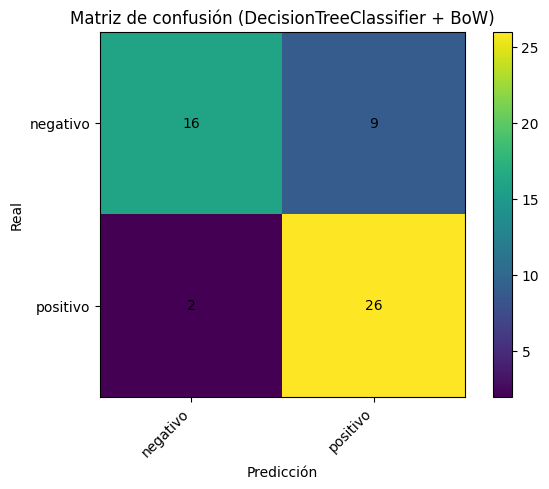

CV Accuracy (TF‑IDF + DecisionTreeClassifier): 0.7952 +/- 0.1092


In [17]:
from sklearn.tree import DecisionTreeClassifier

if 'label' in data.columns:
    y = data['label'].values
else:
    # Si no hay etiqueta, creamos una sintética (solo para mostrar el flujo)
    y = np.array(["positivo" if i % 2 == 0 else "negativo" for i in range(len(data))])

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.25, random_state=42, stratify=y)

# Usando DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

print("Accuracy (DecisionTreeClassifier + BoW):", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Matriz de confusión
labels = sorted(list(set(y)))
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=labels)
plot_confusion_matrix(cm_dt, classes=labels, title="Matriz de confusión (DecisionTreeClassifier + BoW)")

# Cross-validation con TF-IDF para variar la representación
scores_dt = cross_val_score(DecisionTreeClassifier(random_state=42), X_tfidf, y, cv=5)
print("CV Accuracy (TF‑IDF + DecisionTreeClassifier):", scores_dt.mean().round(4), "+/-", scores_dt.std().round(4))

## 9) Agrupación de textos con K‑Means (sobre TF‑IDF)

Etiquetas de clúster (primeras 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Cluster 0 → top términos: convenció, experiencia, and, compra, excelente, buen, servicio, realizada, feliz, empaque
Cluster 1 → top términos: desastre, producto, funciona, calidad, llegó, coincide, descripción, demasiado, caro, ofrece


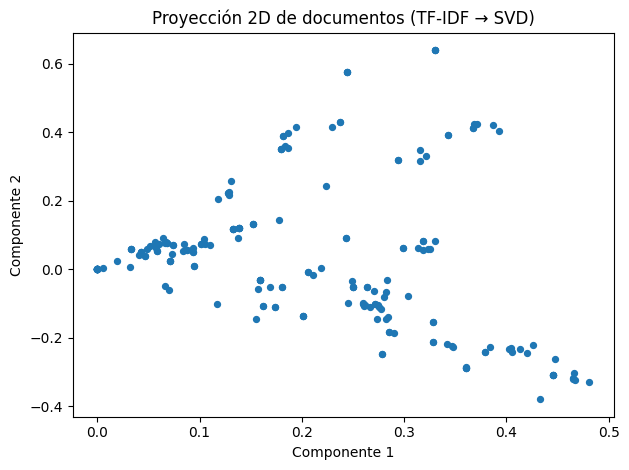

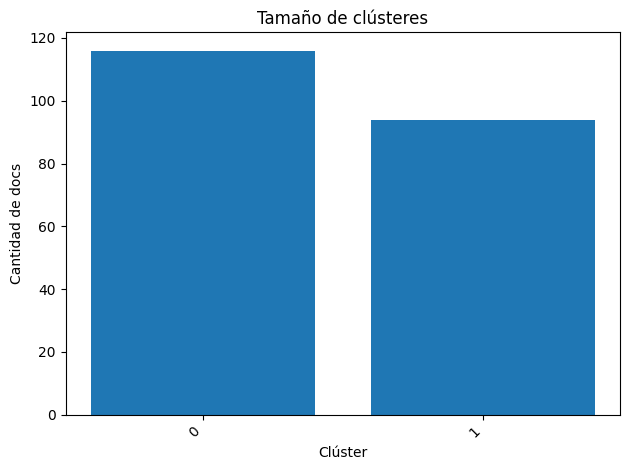

In [20]:
k = 2
km = KMeans(n_clusters=k, n_init=10, random_state=42)
km.fit(X_tfidf)

print("Etiquetas de clúster (primeras 20):", km.labels_[:20])

# Top términos por clúster
terms = tfidf_vec.get_feature_names_out()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top_t = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i} → top términos:", ", ".join(top_t))

# Proyección a 2D para visualizar
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], s=18)
plt.title("Proyección 2D de documentos (TF‑IDF → SVD)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.tight_layout()
plt.show()

# Distribución de tamaños de clúster
unique, counts = np.unique(km.labels_, return_counts=True)
plot_bar([str(u) for u in unique], counts, "Tamaño de clústeres", "Clúster", "Cantidad de docs")

## 10) Exportar resultados

In [19]:
# Guardamos predicciones de test (clasificación) y asignaciones de clúster
out_pred = pd.DataFrame({
    "texto": data.iloc[X_test.nonzero()[0]]['texto'].values if hasattr(X_test, "nonzero") else data.iloc[:len(y_test)]['texto'].values,
    "y_real": y_test,
    "y_pred": y_pred
})
out_pred.to_csv("predicciones_nb.csv", index=False)
print("Archivo 'predicciones_nb.csv' guardado.")

out_clusters = pd.DataFrame({
    "texto": data['texto'],
    "cluster": km.labels_
})
out_clusters.to_csv("clusters_kmeans.csv", index=False)
print("Archivo 'clusters_kmeans.csv' guardado.")

# (En Colab) puedes descargar con:
# from google.colab import files
# files.download('predicciones_nb.csv')
# files.download('clusters_kmeans.csv')

ValueError: All arrays must be of the same length

Etiquetas de clúster (primeras 20): [ 0 -1  1 -1 -1  0  0 -1 -1  2  3 -1  4 -1 -1  1  5  6  9 -1]
Número estimado de clústeres: 20
Número estimado de puntos de ruido: 88


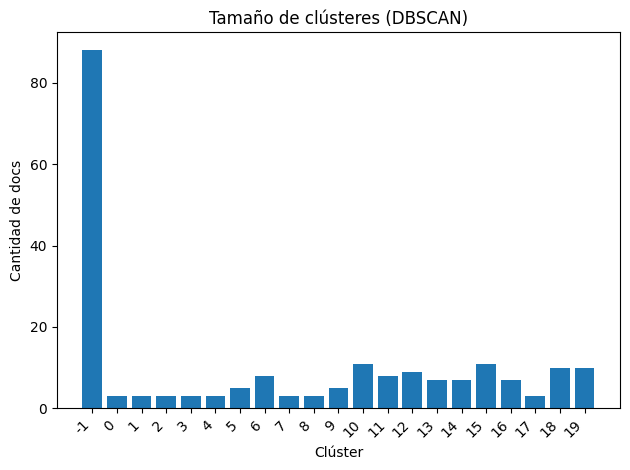

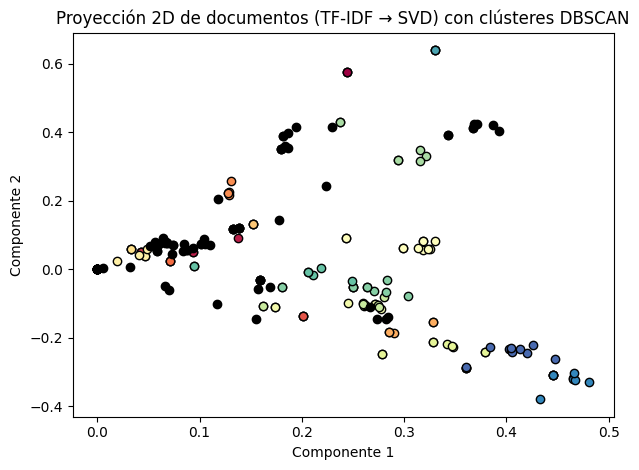

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# DBSCAN is sensitive to scale, so scaling the TF-IDF features is recommended
# However, for sparse matrices like TF-IDF, StandardScaler is not directly applicable.
# We can use TfidfVectorizer with normalized=False and then scale, or use a different approach.
# Given the potential sparsity issues and the focus on the core task, we'll proceed without explicit scaling for this example,
# but it's important to be aware that scaling can impact DBSCAN results.

# Let's use the existing X_tfidf which is already normalized by default in TfidfVectorizer
# If you need to experiment with scaling sparse data, consider methods like Normalizer or custom scaling.

# You might need to tune the parameters 'eps' and 'min_samples' based on your data.
# 'eps' is the maximum distance between two samples for one to be considered as in the neighborhood of the other.
# 'min_samples' is the number of samples in a neighborhood for a point to be considered as a core point.
# A common approach is to use a K-distance plot to help determine a suitable 'eps' value.

# Example with some initial parameters (these might need tuning)
# Try increasing eps or decreasing min_samples if all points are noise.
# Typical ranges for eps might be from 0.1 to 1.0, and min_samples from 2 to 10 or more.
eps_value = 0.8  # Experiment with this value
min_samples_value = 3 # Experiment with this value

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters_dbscan = dbscan.fit_predict(X_tfidf)

print("Etiquetas de clúster (primeras 20):", clusters_dbscan[:20])

# Number of clusters found (ignoring noise, labeled as -1)
n_clusters_ = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_ = list(clusters_dbscan).count(-1)

print(f"Número estimado de clústeres: {n_clusters_}")
print(f"Número estimado de puntos de ruido: {n_noise_}")

# Note: DBSCAN doesn't have centroids in the same way as K-Means.
# To understand the clusters, you might need to inspect the documents within each cluster.

# Distribution of cluster sizes
unique, counts = np.unique(clusters_dbscan, return_counts=True)
plot_bar([str(u) for u in unique], counts, "Tamaño de clústeres (DBSCAN)", "Clúster", "Cantidad de docs")

# Visualization of DBSCAN clusters (requires reducing dimensions)
# We can reuse the SVD reduction from the K-Means section
if 'X_2d' in globals():
    plt.figure()
    # Color points based on cluster label. Noise (-1) can be plotted with a distinct color/marker.
    unique_labels = set(clusters_dbscan)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (clusters_dbscan == k)

        xy = X_2d[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title("Proyección 2D de documentos (TF‑IDF → SVD) con clústeres DBSCAN")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.tight_layout()
    plt.show()